In [127]:
# Cell 1: imports & basic config

import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [128]:
# Cell 2: paths & hyperparameters

img_folder    = "./dataset/G1_G2_band_50_230_noise_F1/img"      # form factor
target_folder = "./dataset/G1_G2_band_50_230_noise_F1/target"   # bunch profile

# img_folder    = "./calculated_form_factor/Figure/"
# target_folder = "./generated_beam_profile/Figure/"

num_exp = 37
sequence_length = 256
batch_size = 256
num_epochs = 200
learning_rate = 1e-3
val_ratio = 0.2


In [129]:
# Cell 3: collect and match file lists

img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".pt")])
tgt_files = sorted([f for f in os.listdir(target_folder) if f.endswith(".pt")])

print("Number of img files   :", len(img_files))
print("Number of target files:", len(tgt_files))

assert len(img_files) == len(tgt_files), "img, target num error!"

for i in range(min(3, len(img_files))):
    print(f"Pair {i}: img={img_files[i]}  <->  target={tgt_files[i]}")


Number of img files   : 25000
Number of target files: 25000
Pair 0: img=G1_gaussian_sample_1.pt  <->  target=G1_gaussian_sample_1.pt
Pair 1: img=G1_gaussian_sample_10.pt  <->  target=G1_gaussian_sample_10.pt
Pair 2: img=G1_gaussian_sample_100.pt  <->  target=G1_gaussian_sample_100.pt


In [130]:
# Cell 4: custom Dataset

class CTRDataset(Dataset):
    def __init__(self, img_folder, tgt_folder, img_files, tgt_files, seq_len=256):
        self.img_folder = img_folder
        self.tgt_folder = tgt_folder
        self.img_files = img_files
        self.tgt_files = tgt_files
        self.seq_len = seq_len

        self.cache_img = {}
        self.cache_tgt = {}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_files[idx])
        tgt_path = os.path.join(self.tgt_folder, self.tgt_files[idx])

        # read form factor
        # df_img = pd.read_csv(img_path)
        # read "F2"
        # F2 = df_img.iloc[:, 1].values if "F2" not in df_img.columns else df_img["F2"].values
        
        # -------- read FF (pt) --------
        # img_sample = torch.load(img_path)
        if img_path not in self.cache_img:
            self.cache_img[img_path] = torch.load(img_path, weights_only=False)
        
        img_sample = self.cache_img[img_path]
        F2 = img_sample["F2"]                        # tensor shape (L,)
        F2 = F2.float()

        # read bunch profile
        # df_tgt = pd.read_csv(tgt_path)
        # read "Intensity"
        # y = df_tgt.iloc[:, 1].values if "Intensity" not in df_tgt.columns else df_tgt["Intensity"].values

        # -------- read bunch profile (pt) --------
        # tgt_sample = torch.load(tgt_path)
        if tgt_path not in self.cache_tgt:
            self.cache_tgt[tgt_path] = torch.load(tgt_path, weights_only=False)

        tgt_sample = self.cache_tgt[tgt_path]
        y = tgt_sample["Intensity"]                  # tensor shape (L,)
        y = y.float()

        # seq_len
        assert len(F2) == self.seq_len, f"Form factor length {len(F2)} != {self.seq_len}"
        assert len(y)  == self.seq_len, f"Bunch length {len(y)} != {self.seq_len}"

        # normalize to 0-1
        F2_norm = F2 / (F2.max() + 1e-8)
        y_norm  = y  / (y.max()  + 1e-8)

        # to tensor
        # img_tensor = torch.tensor(F2_norm, dtype=torch.float32).unsqueeze(0)  # (1, L)
        # tgt_tensor = torch.tensor(y_norm,  dtype=torch.float32).unsqueeze(0)  # (1, L)

        img_tensor = F2_norm.unsqueeze(0)   # shape: (1, L)
        tgt_tensor = y_norm.unsqueeze(0)    # shape: (1, L)

        return img_tensor, tgt_tensor

# 创建完整数据集
full_dataset = CTRDataset(img_folder, target_folder, img_files, tgt_files, seq_len=sequence_length)
print("Total samples in dataset:", len(full_dataset))


Total samples in dataset: 25000


In [131]:
# Cell 5: split into train / val and create DataLoaders

num_total = len(full_dataset)
num_val = int(num_total * val_ratio)
num_train = num_total - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])

print(f"Train samples: {num_train}, Val samples: {num_val}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=4,          
    # pin_memory=True,        
    # persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=4,
    # pin_memory=True,
    # persistent_workers=True
)

Train samples: 20000, Val samples: 5000


In [132]:
# Cell 6: define 1D Dilated ResNet for CTR inverse

class DilatedResBlock(nn.Module):
    def __init__(self, ch, kernel_size=5, dilation=1):
        super().__init__()
        pad = (kernel_size // 2) * dilation

        self.conv = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size,
                      padding=pad, dilation=dilation),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size,
                      padding=pad, dilation=dilation),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))  # residual


class Dilated_CNN_ResNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()

        # first layer
        self.in_conv = nn.Conv1d(in_ch, base_ch, kernel_size=3, padding=1)

        # 6 dilated residual blocks
        self.block1 = DilatedResBlock(base_ch, dilation=1)
        self.block2 = DilatedResBlock(base_ch, dilation=2)
        self.block3 = DilatedResBlock(base_ch, dilation=4)
        self.block4 = DilatedResBlock(base_ch, dilation=8)
        self.block5 = DilatedResBlock(base_ch, dilation=16)
        self.block6 = DilatedResBlock(base_ch, dilation=32)

        # output
        self.out_conv = nn.Conv1d(base_ch, 1, kernel_size=1)

    def forward(self, x):
        x = self.in_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.out_conv(x)
        return x

model = Dilated_CNN_ResNet(in_ch=1, base_ch=64).to(device)

# print(model)


In [133]:
# Cell 7: loss function definition

class AsinhMSEWithPhysicsLoss(nn.Module):
    def __init__(
        self,
        scale=10.0,
        lambda_nonneg=1e0,
        lambda_smooth=1e-2,
    ):
        super().__init__()
        self.scale = scale
        self.lambda_nonneg = lambda_nonneg
        self.lambda_smooth = lambda_smooth

    def forward(self, pred, target):
        # asinh-MSE
        asinh_loss = torch.mean(
            (torch.asinh(pred / self.scale) -
             torch.asinh(target / self.scale)) ** 2
        ) * (self.scale ** 2)

        # non-negative
        nonneg = torch.mean(torch.relu(-pred) ** 2)

        # sommothness
        d2 = pred[:-2] - 2 * pred[1:-1] + pred[2:]
        smooth = torch.mean(d2 ** 2)

        total = (
            asinh_loss
            # + self.lambda_nonneg * nonneg
            # + self.lambda_smooth * smooth
        )

        return total

criterion = AsinhMSEWithPhysicsLoss()


In [134]:
# Cell 8: training & validation loops

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for img, tgt in loader:
        img = img.to(device)   # (B,1,L)
        tgt = tgt.to(device)   # (B,1,L)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, tgt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for img, tgt in loader:
            img = img.to(device)
            tgt = tgt.to(device)
            pred = model(img)
            loss = criterion(pred, tgt)
            running_loss += loss.item() * img.size(0)
    return running_loss / len(loader.dataset)


In [135]:
# Cell 9: run training with TensorBoard logging

# create TensorBoard logs

writer = SummaryWriter(log_dir="./logs/exp{}".format(num_exp))

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss, epoch)

    print(f"Epoch [{epoch:03d}/{num_epochs}] "
          f"Train Loss: {train_loss:.6f}  |  Val Loss: {val_loss:.6f}")
    
    os.makedirs("./model/exp{}".format(num_exp), exist_ok=True)
    torch.save(model, "./model/exp{}/Dilated_ResNet_{}.pth".format(num_exp, epoch))

writer.close()
print("Training finished. Logs saved to ./logs/exp{}".format(num_exp))


Epoch [001/200] Train Loss: 0.028832  |  Val Loss: 0.018411
Epoch [002/200] Train Loss: 0.010430  |  Val Loss: 0.005345
Epoch [003/200] Train Loss: 0.003594  |  Val Loss: 0.002181
Epoch [004/200] Train Loss: 0.001608  |  Val Loss: 0.001415
Epoch [005/200] Train Loss: 0.001122  |  Val Loss: 0.000994
Epoch [006/200] Train Loss: 0.000921  |  Val Loss: 0.001245
Epoch [007/200] Train Loss: 0.000800  |  Val Loss: 0.000760
Epoch [008/200] Train Loss: 0.000734  |  Val Loss: 0.000748
Epoch [009/200] Train Loss: 0.000685  |  Val Loss: 0.000717
Epoch [010/200] Train Loss: 0.000651  |  Val Loss: 0.000605
Epoch [011/200] Train Loss: 0.000595  |  Val Loss: 0.000598
Epoch [012/200] Train Loss: 0.000571  |  Val Loss: 0.000565
Epoch [013/200] Train Loss: 0.000540  |  Val Loss: 0.000548
Epoch [014/200] Train Loss: 0.000550  |  Val Loss: 0.000537
Epoch [015/200] Train Loss: 0.000514  |  Val Loss: 0.000537
Epoch [016/200] Train Loss: 0.000493  |  Val Loss: 0.000614
Epoch [017/200] Train Loss: 0.000482  | 

Loading model: ./model/exp37/Dilated_ResNet_200.pth
Validation samples: 5000


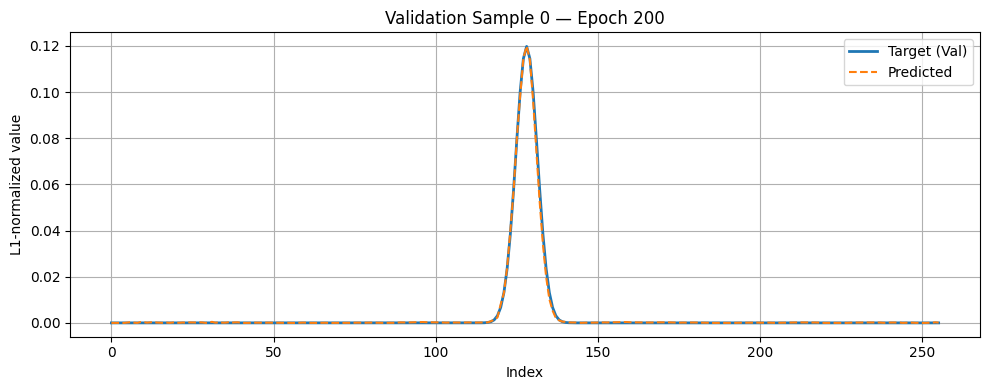

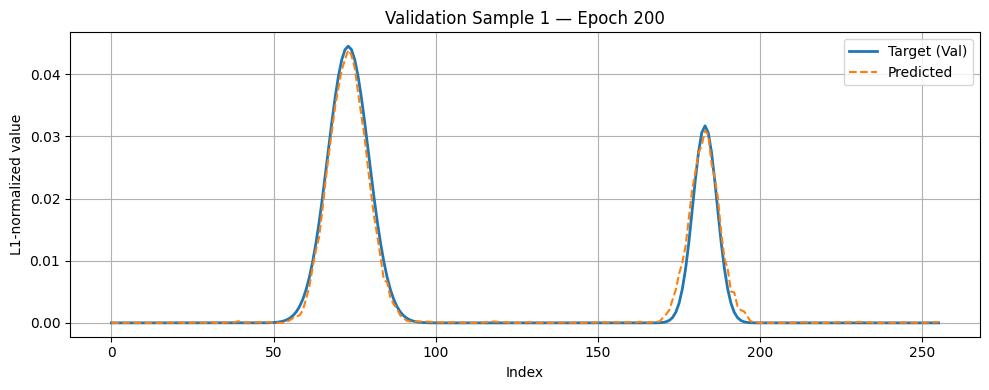

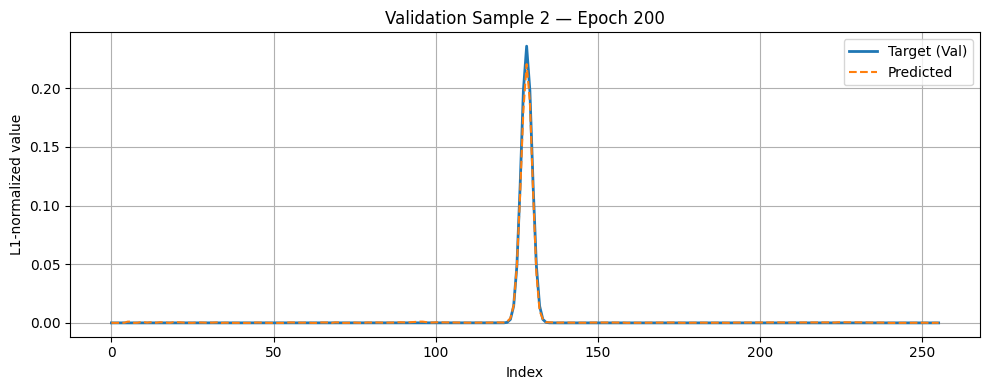

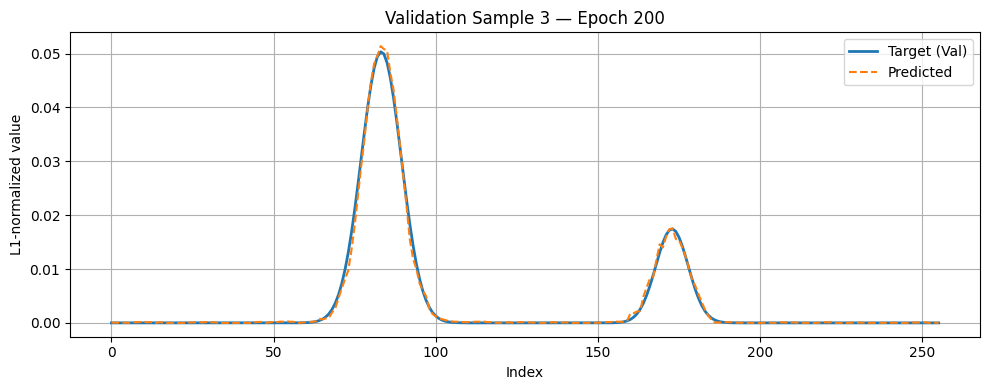

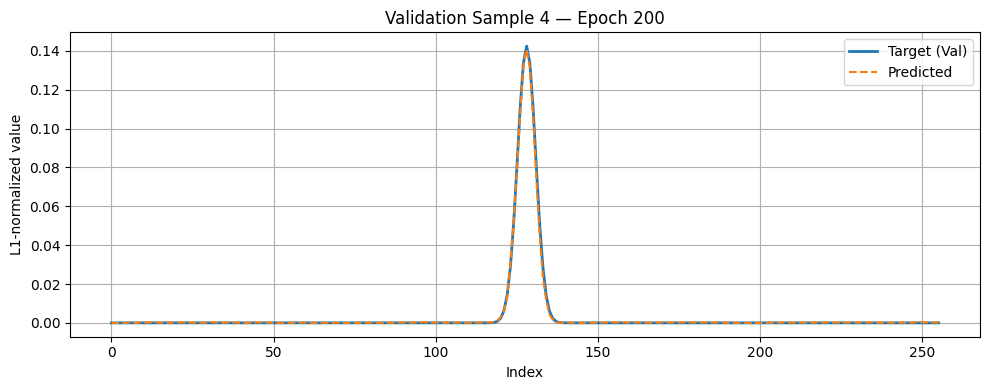

In [136]:
# Cell 10: Load model and visualize ONLY validation set

import matplotlib.pyplot as plt
from torch.serialization import add_safe_globals
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

add_safe_globals([Dilated_CNN_ResNet])

# -----------------------------------------
# Load trained model
# -----------------------------------------
model_path = "./model/exp{}/Dilated_ResNet_200.pth".format(num_exp)
print("Loading model:", model_path)

model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

# -----------------------------------------
# Make sure we are using validation set
# -----------------------------------------
print(f"Validation samples: {len(val_dataset)}")

# number of samples to visualize
num_visualize = 5  

# -----------------------------------------
# Visualization loop (validation only)
# -----------------------------------------
for i in range(min(num_visualize, len(val_dataset))):

    img, tgt = val_dataset[i]   # <-- ONLY val_dataset

    img = img.unsqueeze(0).to(device)     # (1,1,1024)
    tgt = tgt.squeeze().cpu().numpy()     # (1024,)

    # Optional: L1 normalization (保持物理一致)
    tgt = np.clip(tgt, 0, None)
    tgt = tgt / np.sum(tgt)

    with torch.no_grad():
        pred = model(img).squeeze().cpu().numpy()

    pred = np.clip(pred, 0, None)
    pred = pred / np.sum(pred)

    # -----------------------------------------
    # Plot
    # -----------------------------------------
    plt.figure(figsize=(10, 4))

    plt.plot(tgt, label="Target (Val)", linewidth=2)
    plt.plot(pred, label="Predicted", linestyle='--')

    plt.xlabel("Index")
    plt.ylabel("L1-normalized value")
    plt.title(f"Validation Sample {i} — Epoch 200")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [137]:
# Cell 11: Form Factor Calculator

def compute_form_factor(x_um, y, pad_factor=10):
    """
    Compute form factor power spectrum |F(k)|^2 with zero-padding
    to increase frequency-domain resolution.

    pad_factor = how many times to extend array length via zero-padding.
    """

    # ---- Normalize ----
    y_norm = y / np.trapezoid(y, x_um)

    # ---- Zero padding ----
    N = len(y_norm)
    Np = pad_factor * N               # padded size
    y_pad = np.zeros(Np)
    y_pad[:N] = y_norm                # add zeros to the end

    # ---- FFT ----
    Y = np.fft.fft(y_pad)

    # ---- Spatial step and k axis ----
    dx = x_um[1] - x_um[0]            # um
    k = np.fft.fftfreq(Np, d=dx) * 2 * np.pi   # 1/um

    # ---- Form factor power spectrum ----
    F2 = np.abs(Y)**2                 # |F|^2

    return k[:Np//2], F2[:Np//2]


def k_to_THz(k):
    """
    Convert wavenumber k (1/um) to frequency in THz.
    """
    c = 3e8
    k_m = k * 1e6
    return (c * k_m / (2*np.pi)) / 1e12


def plot_bunch_and_form_factor(x_um, y, f_cut_THz=100, pad_factor=10):
    """
    Plot bunch profile and |F|^2 with zero-padding to boost resolution.
    """

    # ---- Bunch profile ----
    plt.figure(figsize=(8,4))
    plt.plot(x_um, y)
    plt.xlabel("x (um)")
    plt.ylabel("Intensity")
    plt.title("Bunch Profile")
    plt.grid()
    plt.show()

    # ---- Compute form factor with padding ----
    k, F2 = compute_form_factor(x_um, y, pad_factor=pad_factor)

    # ---- Convert to frequency ----
    freq_THz = k_to_THz(k)

    # ---- Frequency truncation ----
    mask = (freq_THz >= 0) & (freq_THz <= f_cut_THz)

    # ---- Plot ----
    plt.figure(figsize=(8,4))
    plt.plot(freq_THz[mask], F2[mask])
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|F(f)|²")
    plt.title(f"Form Factor |F|² (Zero-padding ×{pad_factor}) 0–{f_cut_THz} THz")
    plt.grid()
    plt.show()

# ========== reasmple ==========
def resample_to_fixed_length(x, y, out_len=1024):
    x_new = np.linspace(x.min(), x.max(), out_len)
    y_new = np.interp(x_new, x, y)
    return x_new, y_new

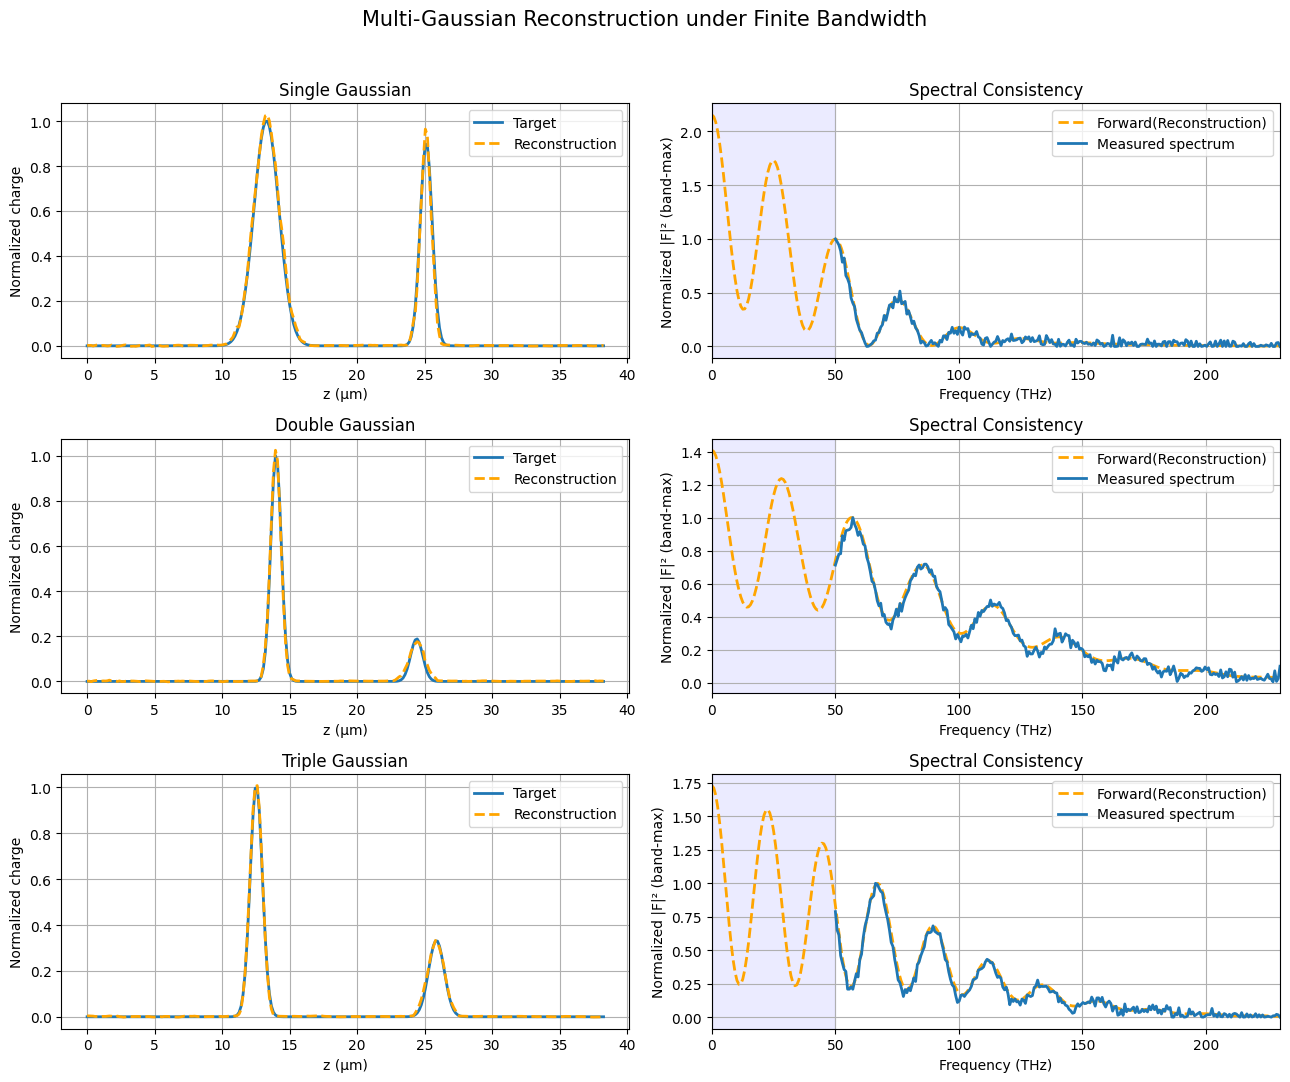

In [138]:
# Cell 12: 3x2 Figure: Full 0–80 THz + band shading + band-max normalization =====

model.eval()

# rep_indices = [5201, 10004, 53005]

rep_indices = [5005, 5003, 5004]
dx = 0.15
f_min = 50
f_max = 230
f_display_max = 230

#dx = 0.4
#f_min = 10
#f_max = 40
#f_display_max = 80
pad_factor = 10

fig, axes = plt.subplots(3, 2, figsize=(13, 11))
fig.suptitle("Multi-Gaussian Reconstruction under Finite Bandwidth", fontsize=15)

for row, idx in enumerate(rep_indices):

    img, tgt = full_dataset[idx]
    img = img.unsqueeze(0).to(device)
    tgt = tgt.squeeze().cpu().numpy()

    with torch.no_grad():
        pred = model(img).squeeze().cpu().numpy()

    # ================= LEFT: profile =================
    N = len(tgt)
    z = np.arange(N) * dx

    ax_left = axes[row, 0]
    ax_left.plot(z, tgt, linewidth=2, label="Target")
    ax_left.plot(z, pred, '--', linewidth=2, color='orange', label="Reconstruction")
    ax_left.set_xlabel("z (μm)")
    ax_left.set_ylabel("Normalized charge")
    ax_left.set_title(["Single Gaussian", "Double Gaussian", "Triple Gaussian"][row])
    ax_left.grid(True)
    ax_left.legend()

    # ================= RIGHT: spectrum =================
    # Forward full spectrum
    k_rec, F2_rec = compute_form_factor(z, pred, pad_factor=pad_factor)
    freq_rec = k_to_THz(k_rec)

    # Keep 0–80 THz for display
    mask_full = (freq_rec >= 0) & (freq_rec <= f_display_max)
    freq_full = freq_rec[mask_full]
    F2_full = F2_rec[mask_full]

    # Measured spectrum exists only in [f_min, f_max]
    spectrum_measured = img.squeeze().cpu().numpy()
    freq_meas = np.linspace(f_min, f_max, len(spectrum_measured))

    # ---- Band-max normalization (key change) ----
    # scale factor for forward: max within band window
    mask_band_full = (freq_full >= f_min) & (freq_full <= f_max)
    if np.any(mask_band_full):
        scale_forward = np.max(F2_full[mask_band_full])
    else:
        scale_forward = np.max(F2_full)

    # scale factor for measured: max within its band (it is already band-only)
    scale_measured = np.max(spectrum_measured)

    # avoid divide-by-zero
    scale_forward = scale_forward if scale_forward > 0 else 1.0
    scale_measured = scale_measured if scale_measured > 0 else 1.0

    ax_right = axes[row, 1]

    # Shade truncated regions (blue translucent), band window stays white
    ax_right.axvspan(0, f_min, color='blue', alpha=0.08)
    ax_right.axvspan(f_max, f_display_max, color='blue', alpha=0.08)

    # Plot forward (full) normalized by band max
    ax_right.plot(
        freq_full,
        F2_full / scale_forward,
        '--',
        linewidth=2,
        color='orange',
        label="Forward(Reconstruction)"
    )

    # Plot measured (band-only) normalized by its band max
    ax_right.plot(
        freq_meas,
        spectrum_measured / scale_measured,
        linewidth=2,
        label="Measured spectrum"
    )

    ax_right.set_xlim(0, f_display_max)
    ax_right.set_xlabel("Frequency (THz)")
    ax_right.set_ylabel("Normalized |F|² (band-max)")
    ax_right.set_title("Spectral Consistency")
    ax_right.grid(True)
    ax_right.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


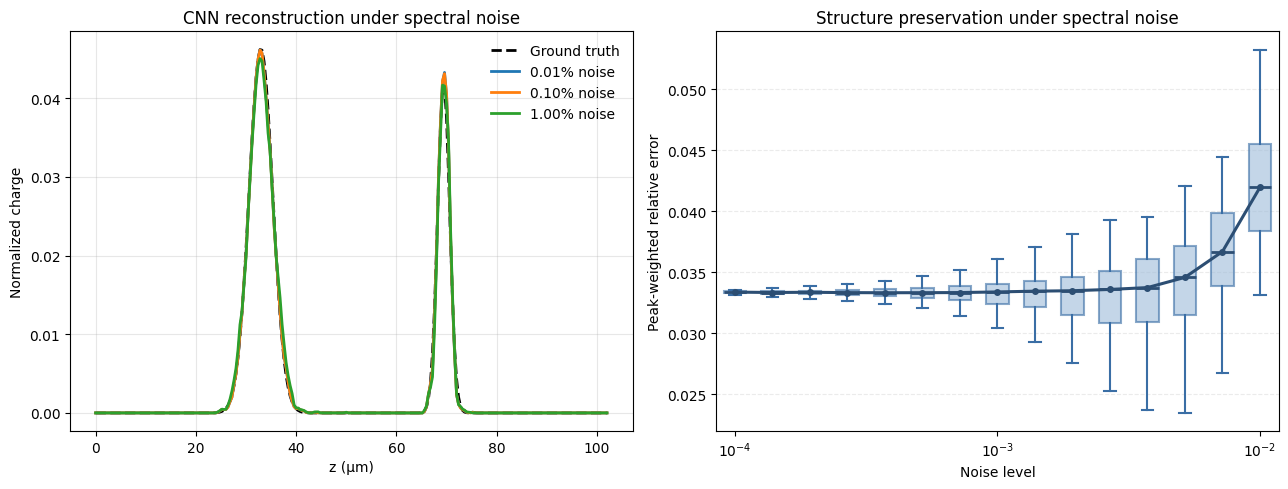

In [52]:
# Cell 13: CNN Noise Robustness (Peak-weighted error)

model.eval()

box_main = "#3A6EA5"
box_fill = "#9DBBD9"
median_color = "#2C4E73"

# -----------------------------------------
# Select one double-Gaussian sample
# -----------------------------------------
double_idx = 23005

img, tgt = full_dataset[double_idx]
img = img.unsqueeze(0).to(device)
tgt = tgt.squeeze().cpu().numpy()

N = len(tgt)
z = np.arange(N) * dx

# ---- L1 normalization ----
tgt = np.clip(tgt, 0, None)
tgt_norm = tgt / np.sum(tgt)
tgt_norm_max = tgt_norm / np.max(tgt_norm)

# -----------------------------------------
# FWHM alignment
# -----------------------------------------
from scipy.ndimage import gaussian_filter1d

def fwhm_center(profile, x):
    if np.max(profile) <= 0:
        return np.mean(x)

    p = gaussian_filter1d(profile, sigma=1)
    peak_idx = np.argmax(p)
    peak_val = p[peak_idx]
    half_val = 0.5 * peak_val

    left_idx = peak_idx
    while left_idx > 0 and p[left_idx] > half_val:
        left_idx -= 1

    right_idx = peak_idx
    while right_idx < len(p)-1 and p[right_idx] > half_val:
        right_idx += 1

    return 0.5 * (x[left_idx] + x[right_idx])

c_true = fwhm_center(tgt_norm_max, z)

def align_by_fwhm(profile):
    profile_max = profile / np.max(profile) if np.max(profile) > 0 else profile
    c = fwhm_center(profile_max, z)
    shift_pts = int(np.round((c - c_true) / dx))
    return np.roll(profile, -shift_pts)

# -----------------------------------------
# Representative reconstructions (LEFT 不动)
# -----------------------------------------
rep_levels = [1e-4, 1e-3, 1e-2]
rep_profiles = []

for nl in rep_levels:

    torch.manual_seed(0)
    noise = nl * torch.randn_like(img)
    img_noisy = torch.clamp(img + noise, min=0.0)

    with torch.no_grad():
        pred = model(img_noisy).squeeze().cpu().numpy()

    pred = np.clip(pred, 0, None)
    pred = pred / np.sum(pred)

    pred_aligned = align_by_fwhm(pred)
    rep_profiles.append((nl, pred_aligned))

# -----------------------------------------
# New error metric (peak-weighted L2)
# -----------------------------------------

# 权重 = true profile（强调结构）
weight = tgt_norm
weight = weight / np.max(weight)

def weighted_error(pred):
    diff = weight * (pred - tgt_norm)
    num = np.linalg.norm(diff)
    den = np.linalg.norm(weight * tgt_norm)
    return num / den

# -----------------------------------------
# Statistical scan
# -----------------------------------------
noise_levels = np.logspace(-4, -2, 15)
n_trials = 50
all_errors = []

for nl in noise_levels:

    trial_errors = []

    for seed in range(n_trials):

        torch.manual_seed(seed)
        noise = nl * torch.randn_like(img)
        img_noisy = torch.clamp(img + noise, min=0.0)

        with torch.no_grad():
            pred = model(img_noisy).squeeze().cpu().numpy()

        pred = np.clip(pred, 0, None)
        pred = pred / np.sum(pred)

        pred_aligned = align_by_fwhm(pred)

        err = weighted_error(pred_aligned)
        trial_errors.append(err)

    all_errors.append(trial_errors)

# =========================================
# Plot
# =========================================

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ---- LEFT (不动) ----
ax1 = axes[0]

ax1.plot(z, tgt_norm, "k--", linewidth=2, label="Ground truth")

for nl, r in rep_profiles:
    ax1.plot(z, r, linewidth=2, label=f"{nl*100:.2f}% noise")

ax1.set_xlabel("z (μm)")
ax1.set_ylabel("Normalized charge")
ax1.set_title("CNN reconstruction under spectral noise")
ax1.legend(frameon=False)
ax1.grid(alpha=0.3)

# ---- RIGHT (new metric) ----
ax2 = axes[1]

idx = np.arange(len(noise_levels))

box = ax2.boxplot(
    all_errors,
    positions=idx,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color=median_color, linewidth=2),
    whiskerprops=dict(color=box_main, linewidth=1.5),
    capprops=dict(color=box_main, linewidth=1.5),
    boxprops=dict(color=box_main, linewidth=1.5),
)

for patch in box["boxes"]:
    patch.set_facecolor(box_fill)
    patch.set_alpha(0.6)

medians = [np.median(e) for e in all_errors]
ax2.plot(idx, medians, color=median_color, linewidth=2.2, marker="o", markersize=4)

ax2.set_xlabel("Noise level")
ax2.set_ylabel("Peak-weighted relative error")
ax2.set_title("Structure preservation under spectral noise")

ax2.set_xticks([0, 7, 14])
ax2.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])

ax2.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 14: GS code

import torch.nn.functional as F
import torch.fft as fft

## start: torch
def _smooth_1d(x: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """
    Convolve 1D tensor x with a 1D kernel (both on same device).
    Reflect padding to avoid edge artifacts.
    """
    x = x.view(1, 1, -1)  # [B,C,L]
    k = kernel.view(1, 1, -1)
    pad = (k.shape[-1] - 1) // 2
    x_pad = F.pad(x, (pad, pad), mode="reflect")
    y = F.conv1d(x_pad, k)
    return y.view(-1)

def get_smoothing_kernel(device="cpu"):
    k = torch.tensor([1., 4., 6., 4., 1.], device=device)
    k = k / k.sum()
    return k

    
def gerchberg_saxton_1d_torch(
    I_meas: torch.Tensor,
    n_iters: int = 500,
    support_mask: torch.Tensor = None,
    smooth: bool = True,
    device: str = "cpu",
) -> torch.Tensor:
    """
    1D Gerchberg–Saxton phase retrieval. 
    Optionally applies a mild smoothing after each iteration.

    I_meas: measured spectrum (|FFT[rho_true]|^2), shape [N]
    support_mask: optional 0/1 mask in z-domain, shape [N]
    
    Returns
    --------
    rho_recon(z)
    """
    device = torch.device(device)
    I_meas = I_meas.to(device)
    N = I_meas.numel()

    # magnitude in frequency domain
    mag_meas = torch.sqrt(torch.clamp(I_meas, min=0.0))

    # random positive real initial guess in z
    rho = torch.rand(N, device=device)
    rho = rho / rho.sum()
    
    kernel = get_smoothing_kernel(device) if smooth else None

    for _ in range(n_iters):
        # forward: z -> k
        F = fft.fft(rho)

        # impose measured magnitude, keep current phase
        phase = torch.exp(1j * torch.angle(F))
        F_new = mag_meas * phase

        # inverse: k -> z
        rho_new = fft.ifft(F_new).real

        # real-space constraints: positivity + optional support
        rho_new = torch.clamp(rho_new, min=0.0)
        if support_mask is not None:
            rho_new = rho_new * support_mask.to(device)
        
        # smoothing (optional)
        if kernel is not None:
            rho_new = _smooth_1d(rho_new, kernel)

        # renormalize total charge
        s = rho_new.sum()
        if s > 0:
            rho_new = rho_new / s

        rho = rho_new

    return rho


##-- start: numpy
def get_smoothing_kernel_numpy():
    k = np.array([1., 4., 6., 4., 1.], dtype=np.float64)
    k = k / k.sum()
    return k


def _smooth_1d_numpy(x: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    1D convolution with reflect padding, analogous to _smooth_1d (Torch).
    """
    pad = (kernel.size - 1) // 2
    x_pad = np.pad(x, pad_width=pad, mode="reflect")
    y = np.convolve(x_pad, kernel, mode="valid")
    return y

def gerchberg_saxton_1d_numpy(
    I_meas_np: np.ndarray,
    n_iters: int = 500,
    support_mask_np: np.ndarray | None = None,
    smooth: bool = True,
    seed: int | None = None,
) -> np.ndarray:
    """
    1D Gerchberg–Saxton phase retrieval (NumPy backend).
    Same logic as gerchberg_saxton_1d_torch but in NumPy.
    """
    I_meas_np = np.asarray(I_meas_np, dtype=np.float64)
    N = I_meas_np.size
    mag_meas = np.sqrt(np.clip(I_meas_np, 0.0, None))

    if support_mask_np is not None:
        support_mask_np = np.asarray(support_mask_np, dtype=np.float64)

    rng = np.random.default_rng(seed)

    # random positive real initial guess
    rho = rng.random(N)
    rho /= rho.sum()

    kernel = get_smoothing_kernel_numpy() if smooth else None

    for _ in range(n_iters):
        # forward: z -> k
        Fk = np.fft.fft(rho)

        # impose measured magnitude, keep current phase
        phase = np.exp(1j * np.angle(Fk))
        F_new = mag_meas * phase

        # inverse: k -> z
        rho_new = np.fft.ifft(F_new).real

        # constraints in real space
        rho_new = np.maximum(rho_new, 0.0)
        if support_mask_np is not None:
            rho_new *= support_mask_np

        if kernel is not None and kernel.size > 1:
            rho_new = _smooth_1d_numpy(rho_new, kernel)

        s = rho_new.sum()
        if s > 0:
            rho_new /= s

        rho = rho_new

    return rho
##--- end: numpy

def forward_spectrum_fft(rho: torch.Tensor):
    """
    Forward model:
        rho(z) -> I(k) = |FFT[rho]|^2
    """
    Fk = torch.fft.fft(rho)
    I = torch.abs(Fk) ** 2
    return I, Fk

## choose backend
def gerchberg_saxton_multistart(
    I_meas: torch.Tensor,
    n_iters: int,
    support_mask: torch.Tensor = None,
    n_restarts: int = 8,
    backend: str = "torch",   # "torch" or "numpy"
    device: str = "cpu",
    seed = None,
) -> torch.Tensor:
    """
    Run GS multiple times with different random initializations and
    return the reconstruction whose spectrum best matches I_meas.

    backend:
        - "torch"  : use gerchberg_saxton_1d_torch
        - "numpy"  : use gerchberg_saxton_1d_numpy
                     (converted back to torch at the end)
    """
    backend = backend.lower()
    device = torch.device(device)
    
    if seed is not None:
        torch.manual_seed(seed)

    if backend == "torch":
         # torch backend
        best_rho = None
        best_loss = float("inf")
        dev = torch.device(device)

        for r in range(n_restarts):
            # different seed per restart for reproducibility
            # torch.manual_seed(r)
            rho = gerchberg_saxton_1d_torch(
                I_meas=I_meas,
                n_iters=n_iters,
                support_mask=support_mask,
                smooth=True,
                device=device,
            )

            I_rec, _ = forward_spectrum_fft(rho)
            loss = torch.mean(
                (torch.log(I_rec + 1e-12) - torch.log(I_meas.to(device) + 1e-12))**2
            )
            if loss.item() < best_loss:
                best_loss = float(loss.item())
                best_rho = rho.detach()

        print(f"[GS-Torch-{dev.type}] best spectral loss over {n_restarts} restarts: {best_loss:.3e}")
        return best_rho.to(device)

    elif backend == "numpy":
        # numpy backend
        I_meas_np = I_meas.detach().cpu().numpy()
        support_np = None if support_mask is None else support_mask.detach().cpu().numpy()

        best_rho_np = None
        best_loss = np.inf

        for r in range(n_restarts):
            rho_np = gerchberg_saxton_1d_numpy(
                I_meas_np=I_meas_np,
                n_iters=n_iters,
                support_mask_np=support_np,
                smooth=True,
                seed=r,
            )

            # compute spectrum and log-MSE in numpy
            Fk = np.fft.fft(rho_np)
            I_rec_np = np.abs(Fk)**2
            loss = np.mean(
                (np.log(I_rec_np + 1e-12) - np.log(I_meas_np + 1e-12))**2
            )

            if loss < best_loss:
                best_loss = float(loss)
                best_rho_np = rho_np.copy()

        print(f"[GS-NumPy] best spectral loss over {n_restarts} restarts: {best_loss:.3e}")

        # convert back to torch for downstream code
        best_rho_torch = torch.from_numpy(best_rho_np).to(device, dtype=I_meas.dtype)
        return best_rho_torch

    else:
        raise ValueError("backend must be 'torch' or 'numpy'")


Loading model: ./model/exp34/Dilated_ResNet_200.pth
Validation samples: 20000


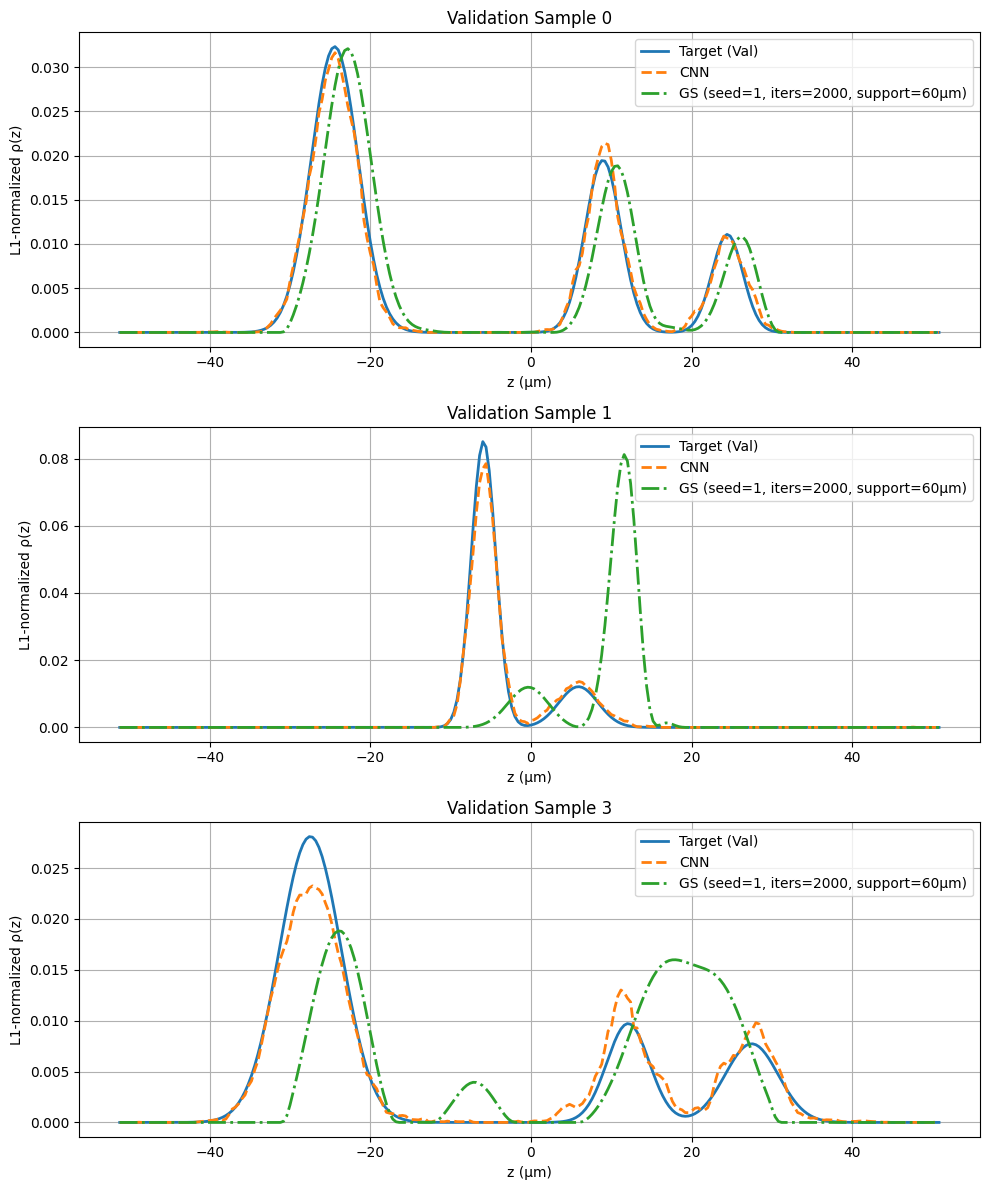

Timing statistics over selected samples
GS (2000 iterations):           504.82 ± 31.91 ms
Neural network (1 forward pass):1.77 ± 0.39 ms


In [ ]:
# Cell 15: CNN (unchanged) + GS (Figure2-style forward)


import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
add_safe_globals([Dilated_CNN_ResNet])

# -----------------------------------------
# Load trained model
# -----------------------------------------
model_path = "./model/exp{}/Dilated_ResNet_200.pth".format(num_exp)
print("Loading model:", model_path)

model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

print(f"Validation samples: {len(val_dataset)}")

# -----------------------------------------
# Settings
# -----------------------------------------
dx = 0.4
gs_iters = 2000
gs_seed = 1
use_support = True
support_width_um = 60

selected_indices = [0, 1, 3]

# -----------------------------------------
# Timing containers
# -----------------------------------------
nn_times = []
gs_times = []

# -----------------------------------------
# Create figure
# -----------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

for ax, i in zip(axes, selected_indices):

    img, tgt = val_dataset[i]
    img = img.unsqueeze(0).to(device)
    tgt_np = tgt.squeeze().cpu().numpy()

    tgt_np = np.clip(tgt_np, 0, None)
    tgt_np = tgt_np / np.sum(tgt_np)

    # ===============================
    # CNN timing
    # ===============================
    torch.cuda.synchronize() if device.type == "cuda" else None
    start_nn = time.perf_counter()

    with torch.no_grad():
        pred_cnn = model(img)

    torch.cuda.synchronize() if device.type == "cuda" else None
    end_nn = time.perf_counter()

    nn_time_ms = (end_nn - start_nn) * 1000
    nn_times.append(nn_time_ms)

    pred_cnn = pred_cnn.squeeze().cpu().numpy()
    pred_cnn = np.clip(pred_cnn, 0, None)
    pred_cnn = pred_cnn / np.sum(pred_cnn)

    # -----------------------------------------
    # GS forward
    # -----------------------------------------
    rho_true = torch.tensor(tgt_np, dtype=torch.float32, device=device)

    I_meas, _ = forward_spectrum_fft(rho_true)
    I_meas = I_meas.real
    I_meas = I_meas / torch.max(I_meas)

    N = rho_true.numel()
    z_um = (np.arange(N) - N // 2) * dx

    if use_support:
        support_mask_np = (np.abs(z_um) <= support_width_um / 2).astype(np.float32)
        support_mask = torch.tensor(support_mask_np, dtype=torch.float32, device=device)
    else:
        support_mask = None

    torch.manual_seed(gs_seed)

    # ===============================
    # GS timing
    # ===============================
    torch.cuda.synchronize() if device.type == "cuda" else None
    start_gs = time.perf_counter()

    rho_gs = gerchberg_saxton_1d_torch(
        I_meas=I_meas,
        n_iters=gs_iters,
        support_mask=support_mask,
        smooth=True,
        device=device,
    )

    torch.cuda.synchronize() if device.type == "cuda" else None
    end_gs = time.perf_counter()

    gs_time_ms = (end_gs - start_gs) * 1000
    gs_times.append(gs_time_ms)

    rho_gs = rho_gs.detach().cpu().numpy()
    rho_gs = np.clip(rho_gs, 0, None)
    rho_gs = rho_gs / np.sum(rho_gs)

    # -----------------------------------------
    # Plot
    # -----------------------------------------
    ax.plot(z_um, tgt_np, linewidth=2, label="Target (Val)")
    ax.plot(z_um, pred_cnn, linestyle="--", linewidth=2, label="CNN")
    ax.plot(z_um, rho_gs, linestyle="-.", linewidth=2,
            label=f"GS (seed={gs_seed}, iters={gs_iters}"
                  + (f", support={support_width_um}μm" if use_support else "") + ")")

    ax.set_xlabel("z (μm)")
    ax.set_ylabel("L1-normalized ρ(z)")
    ax.set_title(f"Validation Sample {i}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# =========================================
# Timing statistics
# =========================================

nn_times = np.array(nn_times)
gs_times = np.array(gs_times)

print("=========================================")
print("Timing statistics over selected samples")
print("=========================================")
print(f"GS (2000 iterations):           {gs_times.mean():.2f} ± {gs_times.std():.2f} ms")
print(f"Neural network (1 forward pass):{nn_times.mean():.2f} ± {nn_times.std():.2f} ms")


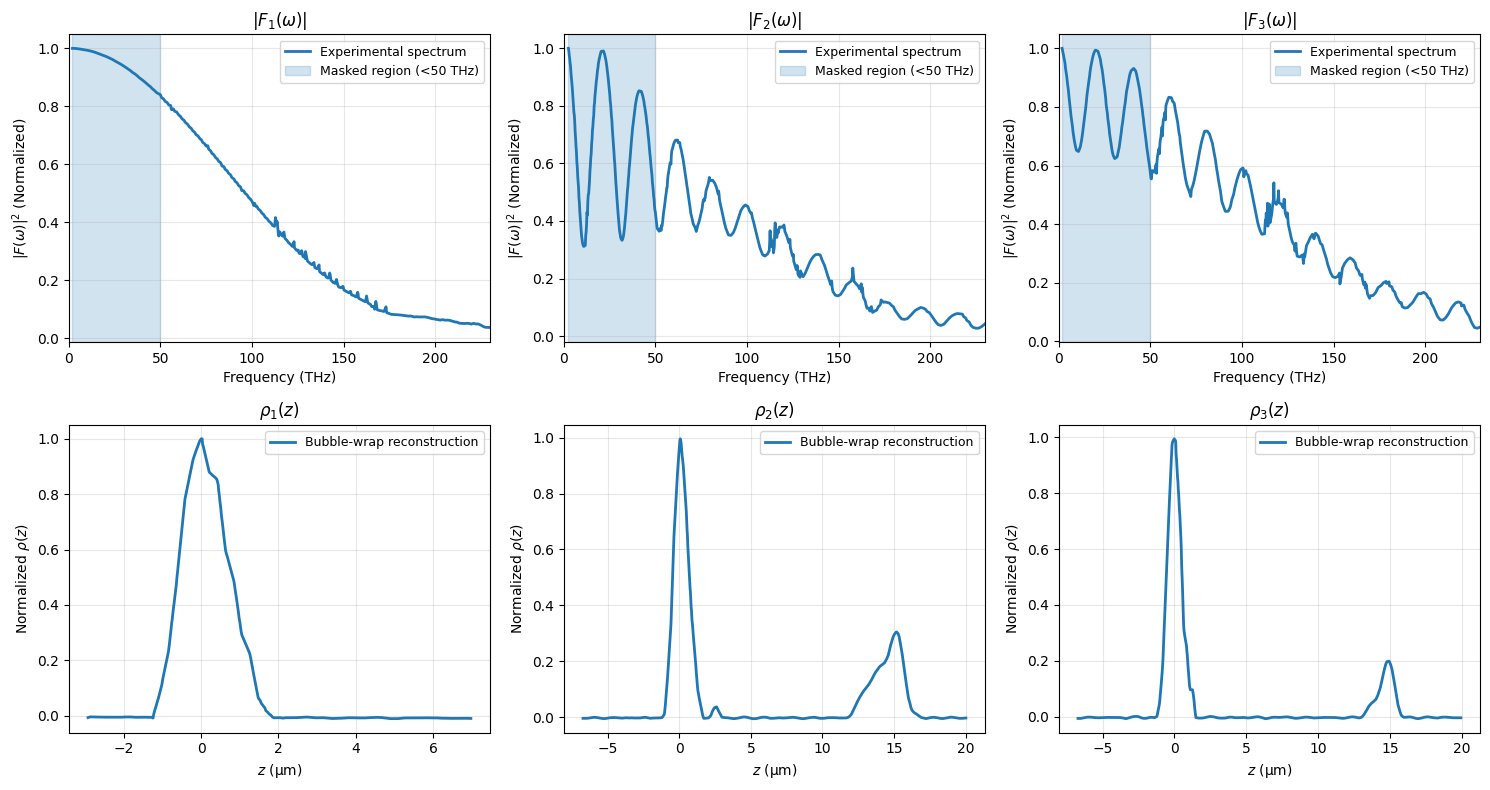

In [ ]:
# =========================================
# Cell 16: Bubble Wrap Results + Forward Overlay
# =========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# =========================================
# Config
# =========================================
folder = "./bubble wrap"
target_points = 1024
mask_threshold = 50  # THz
pad_factor = 10

file_order = [
    "F1.csv", "F2.csv", "F3.csv",
    "rho1.csv", "rho2.csv", "rho3.csv"
]

# =========================================
# Resample helper
# =========================================
def resample_to_1024(x, y, n=1024):
    f_interp = interp1d(x, y, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(np.min(x), np.max(x), n)
    y_new = f_interp(x_new)
    return x_new, y_new


# =========================================
# First pass: load all rho (needed for FFT)
# =========================================
rho_dict = {}

for filename in file_order:
    if filename.startswith("rho"):
        path = os.path.join(folder, filename)
        data = pd.read_csv(path)

        x = data.iloc[:, 0].values.astype(float)
        y = data.iloc[:, 1].values.astype(float)

        x_res, y_res = resample_to_1024(
            x,
            y / np.max(np.abs(y)),
            target_points
        )

        rho_dict[filename[3]] = (x_res, y_res)


# =========================================
# Plot
# =========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, filename in enumerate(file_order):

    path = os.path.join(folder, filename)
    data = pd.read_csv(path)

    x = data.iloc[:, 0].values.astype(float)
    y = data.iloc[:, 1].values.astype(float)

    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # =====================================
    # F(ω) processing
    # =====================================
    if filename.startswith("F"):

        omega = x * 1e14
        freq_THz = omega / (2 * np.pi) / 1e12

        y_norm = y / np.max(np.abs(y))
        x_res, y_res = resample_to_1024(freq_THz, y_norm, target_points)

        # ---- Plot experimental spectrum ----
        ax.plot(x_res, y_res,
                linewidth=2, label="Experimental spectrum")

        # ---- Forward from corresponding rho ----
        case_id = filename[1]
        x_rho, rho = rho_dict[case_id]

        k, F2 = compute_form_factor(x_rho, rho, pad_factor=pad_factor)
        freq_forward = k_to_THz(k)

        mask = (freq_forward >= 0)
        freq_forward = freq_forward[mask]
        F2 = F2[mask]

        F2_norm = F2 / np.max(F2)

        # ax.plot(freq_forward, F2_norm,
        #         '--', linewidth=2,
        #         label="Forward from profile")

        # ---- Mask shading ----
        ax.axvspan(
            x_res.min(),
            mask_threshold,
            color="tab:blue",
            alpha=0.2,
            label="Masked region (<50 THz)"
        )

        ax.set_xlabel("Frequency (THz)")
        ax.set_ylabel(r"$|F(\omega)|^2$ (Normalized)")
        ax.set_xlim(0, 230)

        index = filename[1]
        ax.set_title(rf"$|F_{index}(\omega)|$")
        ax.legend(loc="upper right", fontsize=9)
        ax.grid(alpha=0.3)

    # =====================================
    # rho(z) processing
    # =====================================
    else:

        x_res, y_res = resample_to_1024(
            x,
            y / np.max(np.abs(y)),
            target_points
        )

        ax.plot(x_res, y_res,
                linewidth=2,
                label="Bubble-wrap reconstruction")

        ax.set_xlabel(r"$z$ (μm)")
        ax.set_ylabel(r"Normalized $\rho(z)$")

        index = filename[3]
        ax.set_title(rf"$\rho_{index}(z)$")
        ax.legend(loc="upper right", fontsize=9)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


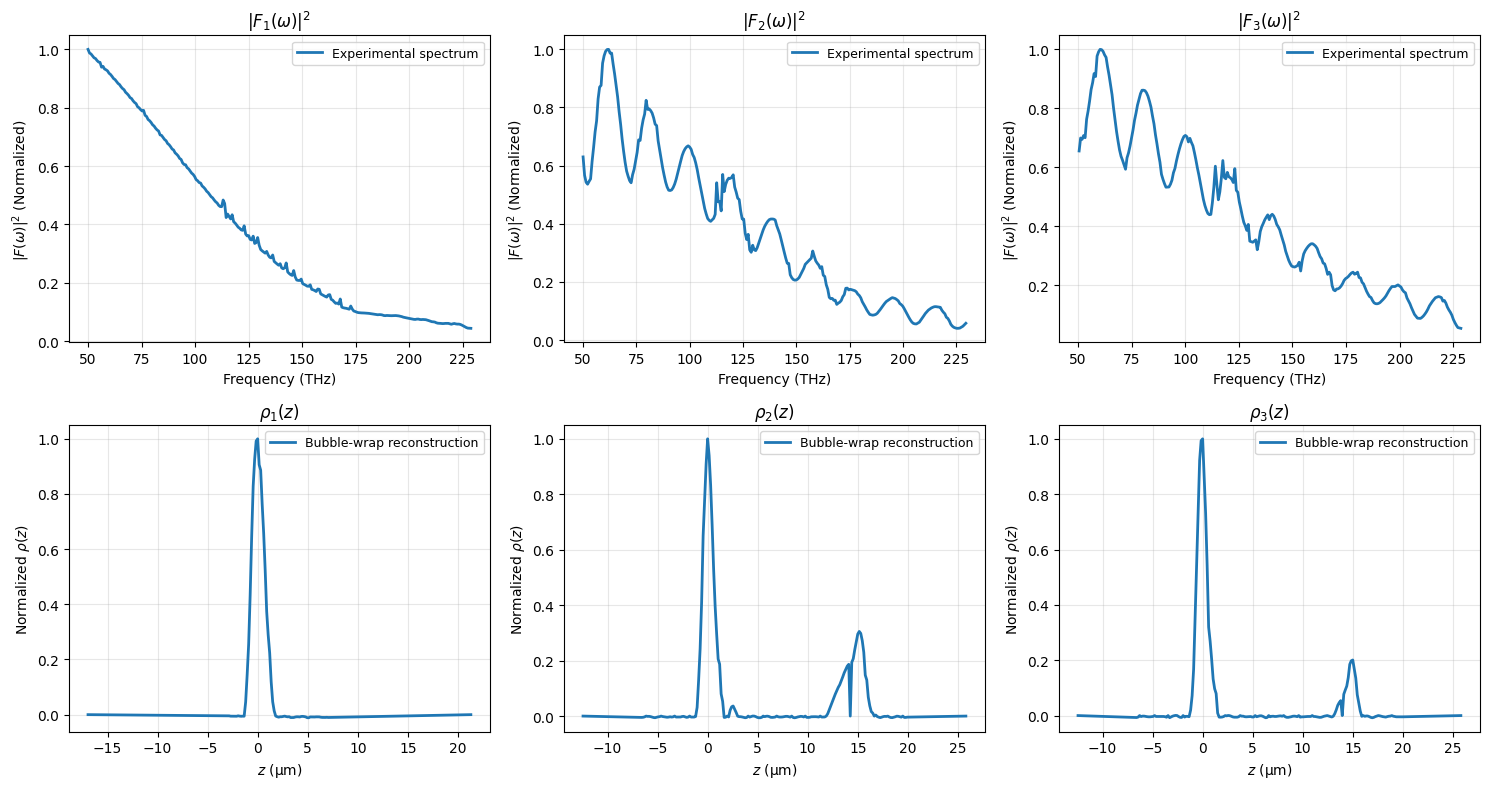

F_list lengths: [256, 256, 256]
rho_list lengths: [256, 256, 256]


In [ ]:
# =========================================
# Cell17: Rescaling (with saving lists)
# =========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# =========================================
# Config
# =========================================
folder = "./bubble wrap"
target_points = 256
mask_threshold = 50  # THz
dx = 0.15  # um per index

file_order = [
    "F1.csv", "F2.csv", "F3.csv",
    "rho1.csv", "rho2.csv", "rho3.csv"
]

# 🔵 新增：保存处理后的数据
F_list = []
rho_list = []

# =========================================
# Resample helper
# =========================================
def resample(x, y, n=256):
    f_interp = interp1d(x, y, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(np.min(x), np.max(x), n)
    y_new = f_interp(x_new)
    return x_new, y_new


# =========================================
# Plot
# =========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, filename in enumerate(file_order):

    path = os.path.join(folder, filename)
    data = pd.read_csv(path)

    x = data.iloc[:, 0].values.astype(float)
    y = data.iloc[:, 1].values.astype(float)

    # =====================================
    # F(ω) processing
    # =====================================
    if filename.startswith("F"):

        omega = x * 1e14
        freq_THz = omega / (2 * np.pi) / 1e12

        mask = (freq_THz >= 50) & (freq_THz <= 230)
        freq_crop = freq_THz[mask]
        y_crop = y[mask]

        y_crop = y_crop / np.max(np.abs(y_crop))

        x_res, y_res = resample(freq_crop, y_crop, target_points)

        # 🔵 保存
        F_list.append(y_res.copy())

        xlabel = "Frequency (THz)"
        ylabel = r"$|F(\omega)|^2$ (Normalized)"
        index = filename[1]
        title = rf"$|F_{index}(\omega)|^2$"
        legend_label = "Experimental spectrum"

    # =====================================
    # rho(z) processing
    # =====================================
    else:

        index_coord = x / dx
        index_coord = np.round(index_coord).astype(int)

        sort_idx = np.argsort(index_coord)
        index_coord = index_coord[sort_idx]
        y_sorted = y[sort_idx]

        idx_min = index_coord.min()
        idx_max = index_coord.max()

        full_index = np.arange(idx_min, idx_max + 1)
        full_rho = np.zeros_like(full_index, dtype=float)

        full_rho[index_coord - idx_min] = y_sorted

        full_rho = full_rho / np.max(np.abs(full_rho))

        current_len = len(full_rho)

        if current_len > target_points:
            start = (current_len - target_points) // 2
            full_rho = full_rho[start:start+target_points]
            full_index = full_index[start:start+target_points]
        else:
            pad_total = target_points - current_len
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left

            full_rho = np.pad(full_rho, (pad_left, pad_right))
            full_index = np.pad(
                full_index,
                (pad_left, pad_right),
                mode='constant',
                constant_values=(
                    full_index[0] - pad_left,
                    full_index[-1] + pad_right
                )
            )

        x_res = full_index * dx
        y_res = full_rho

        # 🔵 保存
        rho_list.append(y_res.copy())

        xlabel = r"$z$ (μm)"
        ylabel = r"Normalized $\rho(z)$"
        index = filename[3]
        title = rf"$\rho_{index}(z)$"
        legend_label = "Bubble-wrap reconstruction"

    # =====================================
    # Plot
    # =====================================
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    ax.plot(x_res, y_res, linewidth=2, label=legend_label)

    if filename.startswith("F"):
        ax.axvspan(50, 50, alpha=0)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 🔵 确认长度
print("F_list lengths:", [len(f) for f in F_list])
print("rho_list lengths:", [len(r) for r in rho_list])


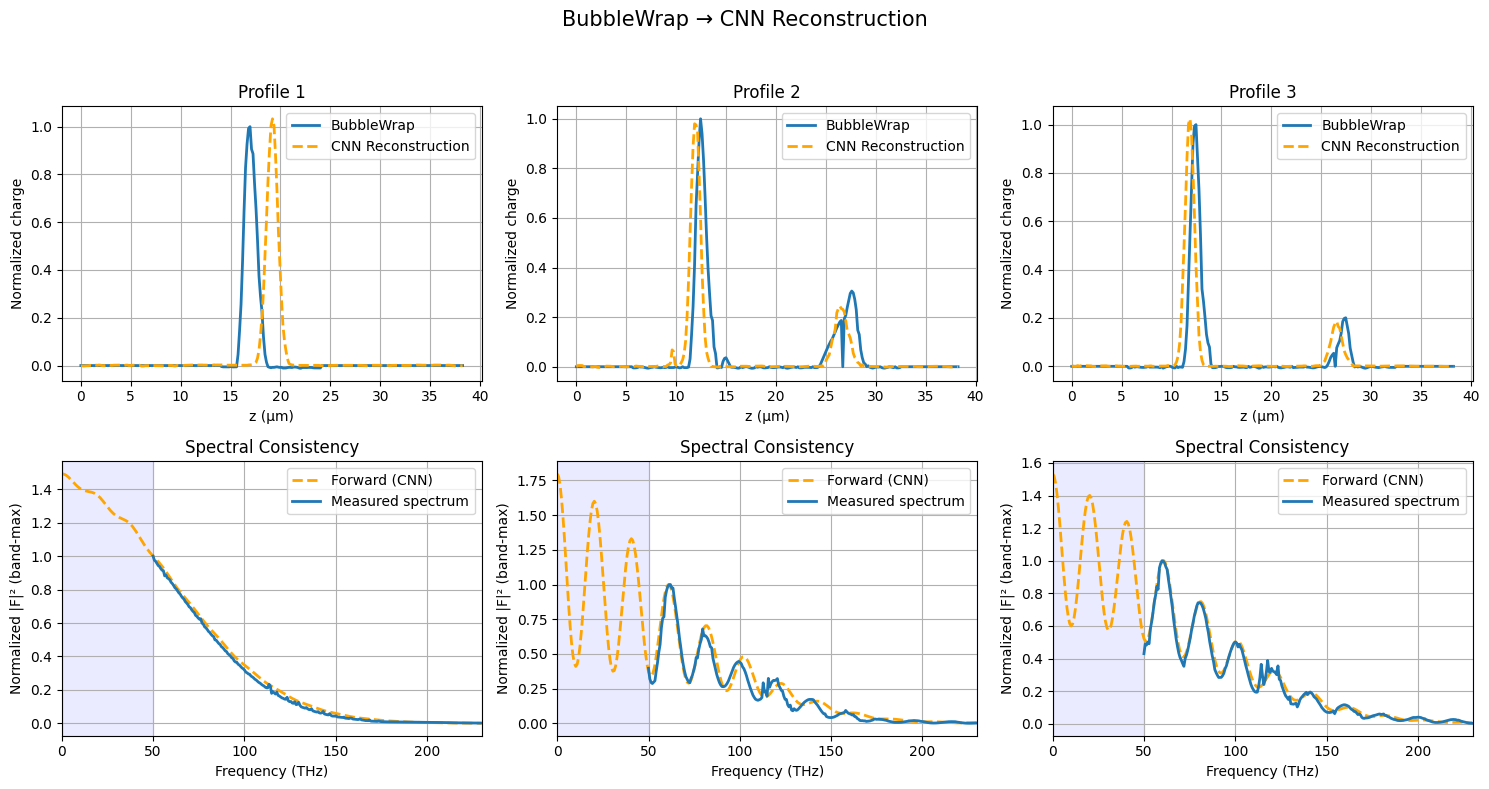

In [ ]:
# =========================================
# Cell 18: BubbleWrap → CNN Reconstruction
# 2 × 3 layout version
# =========================================

model.eval()
device = next(model.parameters()).device

dx = 0.15
f_min = 50
f_max = 230
f_display_max = 230
pad_factor = 10

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("BubbleWrap → CNN Reconstruction", fontsize=15)

titles = ["Profile 1", "Profile 2", "Profile 3"]

for col in range(3):

    # === 直接使用 Cell18 的结果 ===
    F_np = F_list[col]
    rho_np = rho_list[col]

    # 转成 tensor 输入模型
    img = torch.tensor(F_np * F_np, dtype=torch.float32).unsqueeze(0).to(device)
    tgt = rho_np  # numpy

    # forward
    with torch.no_grad():
        pred = model(img).squeeze().cpu().numpy()

    # ================= TOP ROW: profile =================
    N = len(tgt)
    z = np.arange(N) * dx

    ax_top = axes[0, col]
    ax_top.plot(z, tgt, linewidth=2, label="BubbleWrap")
    ax_top.plot(z, pred, '--', linewidth=2, color='orange', label="CNN Reconstruction")
    ax_top.set_xlabel("z (μm)")
    ax_top.set_ylabel("Normalized charge")
    ax_top.set_title(titles[col])
    ax_top.grid(True)
    ax_top.legend()

    # ================= BOTTOM ROW: spectrum =================
    k_rec, F2_rec = compute_form_factor(z, pred, pad_factor=pad_factor)
    freq_rec = k_to_THz(k_rec)

    mask_full = (freq_rec >= 0) & (freq_rec <= f_display_max)
    freq_full = freq_rec[mask_full]
    F2_full = F2_rec[mask_full]

    spectrum_measured = F_np * F_np
    freq_meas = np.linspace(f_min, f_max, len(spectrum_measured))

    mask_band_full = (freq_full >= f_min) & (freq_full <= f_max)
    if np.any(mask_band_full):
        scale_forward = np.max(F2_full[mask_band_full])
    else:
        scale_forward = np.max(F2_full)

    scale_measured = np.max(spectrum_measured)

    scale_forward = scale_forward if scale_forward > 0 else 1.0
    scale_measured = scale_measured if scale_measured > 0 else 1.0

    ax_bottom = axes[1, col]

    ax_bottom.axvspan(0, f_min, color='blue', alpha=0.08)
    ax_bottom.axvspan(f_max, f_display_max, color='blue', alpha=0.08)

    ax_bottom.plot(
        freq_full,
        F2_full / scale_forward,
        '--',
        linewidth=2,
        color='orange',
        label="Forward (CNN)"
    )

    ax_bottom.plot(
        freq_meas,
        spectrum_measured / scale_measured,
        linewidth=2,
        label="Measured spectrum"
    )

    ax_bottom.set_xlim(0, f_display_max)
    ax_bottom.set_xlabel("Frequency (THz)")
    ax_bottom.set_ylabel("Normalized |F|² (band-max)")
    ax_bottom.set_title("Spectral Consistency")
    ax_bottom.grid(True)
    ax_bottom.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
